When benchmarking you **MUST**

1. close all applications
2. close docker
3. close all but this Web windows
4. all pen editors other than jupyter-lab (this notebook)


In [1]:
import os
from cloudmesh.common.Shell import Shell
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pandas as pd
from tqdm.notebook import tqdm
from cloudmesh.common.util import readfile
from cloudmesh.common.util import writefile
from cloudmesh.common.StopWatch import StopWatch 
from cloudmesh.common.systeminfo import systeminfo
import ipywidgets as widgets

sns.set_theme(style="whitegrid")
info = systeminfo()

/home/green/ENV3/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:

user = info["user"] 
node = info["uname.node"]
processors = 4

In [3]:
# Parameters
user = "gregor"
node = "alienware"
processors = 29


In [4]:
p = widgets.IntSlider(
    value=processors,
    min=1,
    max=64,
    step=1,
    description='Processors:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
u = widgets.Text(value=user, placeholder='The user name', description='User:', disabled=False)
n = widgets.Text(value=node, placeholder='The computer name', description='Computer:', disabled=False)

display(p)
display(u)
display(n)

IntSlider(value=29, continuous_update=False, description='Processors:', max=64, min=1)

Text(value='gregor', description='User:', placeholder='The user name')

Text(value='alienware', description='Computer:', placeholder='The computer name')

In [5]:
processors = p.value
user = u.value
node = n.value
print (processors, user, node)

29 gregor alienware


In [6]:

experiments = 10
maximum = 1024 * 100000
intervals = 10

In [7]:
label = f"{user}-{node}-{processors}"
output = f"benchmark/{user}"

delta = int(maximum / intervals)

totals = [64] + list(range(0,maximum, delta))[1:]
points = [int(t/processors) for t in totals]
print (totals)
print(points)

[64, 10240000, 20480000, 30720000, 40960000, 51200000, 61440000, 71680000, 81920000, 92160000]
[2, 353103, 706206, 1059310, 1412413, 1765517, 2118620, 2471724, 2824827, 3177931]


In [8]:
os.makedirs(output, exist_ok=True)

In [9]:
systeminfo = StopWatch.systeminfo({"user": user, "uname.node": node})
writefile(f"{output}/{label}-sysinfo.log", systeminfo)
print (systeminfo)

+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | hirsute                                                          |
| DISTRIB_DESCRIPTION | "Ubuntu 21.04"                                                   |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 21.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           |

In [10]:
df = pd.DataFrame(
{"Size": points}
)
df = df.set_index('Size')

In [11]:


experiment_progress = tqdm(range(0, experiments), desc ="Experiment")

experiment = -1
for experiment in experiment_progress:
    exoeriment = experiment + 1

    log = f"{output}/{label}-{experiment}-log.log"
    os.system(f"rm {log}")


    name = points[experiment]
    progress = tqdm(range(0, len(points)), 
                    desc =f"Benchmark {name}",
                    bar_format="{desc:<30} {total_fmt} {r_bar}")
    
    i = -1
    for state in progress:
        i = i + 1
        n = points[i]
        #if linux, os:
        command = f"mpiexec -n {processors} python count-click.py " + \
                  f"--n {n} --max_number 10 --find 8 --label {label} " + \
                  f"--user {user} --node={node} " + \
                  f"| tee -a {log}"
        #if windows: 
        #command = f"mpiexec -n {processors} python count-click.py " + \
        #          f"--n {n} --max_number 10 --find 8 --label {label} " + \
        #          f"--user {user} --node={node} " + \
        #          f">> {log}"
        
        os.system (command)

    content = readfile(log).splitlines()
    lines = Shell.cm_grep(content, "csv,Result:")
    # print(lines)
    values = []
    times = []

    for line in lines:
        msg = line.split(",")[7]
        t = line.split(",")[4]

        total, overall, trials, find, label = msg.split(" ")
        values.append(int(overall))
        times.append(float(t))
        # print (t, overall)


    #data = pd.DataFrame(values, times, columns=["Values", "Time"])

    #print (data.describe())
    #sns.lineplot(data=data, palette="tab10", linewidth=2.5)
    # df["Size"] = values
    df[f"Time_{experiment}"] = times
    # print(df)


Experiment:   0%|          | 0/10 [00:00<?, ?it/s]

Benchmark 2                    10 | 0/10 [00:00<?, ?it/s]

Benchmark 353103               10 | 0/10 [00:00<?, ?it/s]

Benchmark 706206               10 | 0/10 [00:00<?, ?it/s]

Benchmark 1059310              10 | 0/10 [00:00<?, ?it/s]

Benchmark 1412413              10 | 0/10 [00:00<?, ?it/s]

Benchmark 1765517              10 | 0/10 [00:00<?, ?it/s]

Benchmark 2118620              10 | 0/10 [00:00<?, ?it/s]

Benchmark 2471724              10 | 0/10 [00:00<?, ?it/s]

Benchmark 2824827              10 | 0/10 [00:00<?, ?it/s]

Benchmark 3177931              10 | 0/10 [00:00<?, ?it/s]

In [12]:

df = df.rename_axis(columns="Time")
df
    

Time,Time_0,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8,Time_9
Size,,,,,,,,,,
2,0.006,0.060,0.002,0.009,0.005,0.006,0.005,0.002,0.012,0.005
353103,0.516,0.503,0.494,0.597,0.501,0.509,0.497,0.502,0.498,0.499
706206,1.126,1.181,0.989,1.011,1.017,0.991,0.989,0.981,0.992,1.011
1059310,1.519,1.511,1.533,1.488,1.530,1.499,1.479,1.500,1.534,1.499
1412413,2.041,1.964,2.021,1.982,2.041,2.021,1.977,2.030,1.984,2.056
1765517,2.522,2.532,2.499,2.469,2.484,2.479,2.500,2.490,2.491,2.496
2118620,2.992,3.021,2.972,3.012,3.048,3.044,3.024,3.028,2.994,2.970
2471724,3.558,3.518,3.527,3.481,3.570,3.496,3.486,3.482,3.484,3.458
2824827,4.059,4.120,3.984,4.092,3.963,3.958,3.982,3.998,3.964,3.988


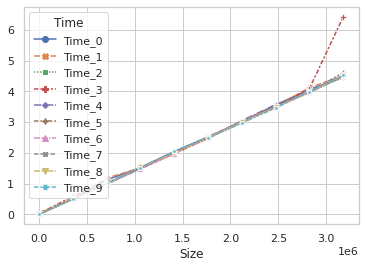

In [13]:
sns.lineplot(data=df, markers=True);

In [14]:
plt.savefig(f'{output}/{label}-line.png');
plt.savefig(f'{output}/{label}-line.pdf');

<Figure size 432x288 with 0 Axes>

In [15]:
dfs = df.stack().reset_index()
dfs = dfs.set_index('Size')
dfs = dfs.drop(columns=['Time'])
dfs = dfs.rename(columns={0:'Time'})
dfs

,Time
Size,
2,0.006
2,0.060
2,0.002
2,0.009
2,0.005
...,...
3177931,4.620
3177931,4.537
3177931,4.509


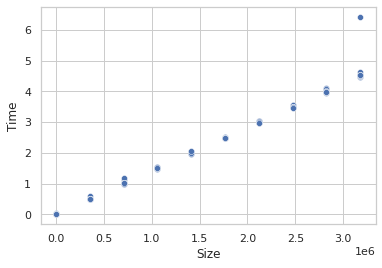

In [16]:
sns.scatterplot(data=dfs, x="Size", y="Time");
plt.savefig(f"{output}/{label}-scatter.pdf")
plt.savefig(f"{output}/{label}-scatter.png")

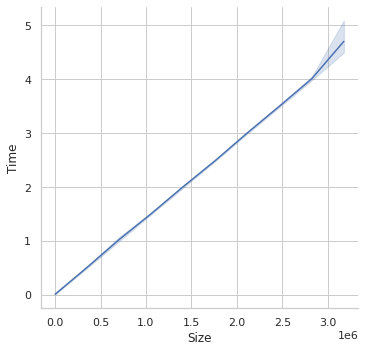

In [17]:
sns.relplot(x="Size", y="Time", kind="line", data=dfs);
plt.savefig(f"{output}/{label}-relplot.pdf")
plt.savefig(f"{output}/{label}-relplot.png")

In [18]:
df.to_pickle(f"{output}/{label}-df.pkl")